In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics
import pywt

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import dataloaders, transforms, OhModel, pytorch_msssim

# Paths
PATH_SAVE_NETWORK_INTERMEDIATE = "./runs/OhModel_v10/nets_int_135.tar"
directory_source = "D:/data/JSRT/augmented/test/source/"
directory_boneless = "D:/data/JSRT/augmented/test/target/"

# Data
_batch_size = 10
image_spatial_size = (512,512)

discriminator_keys_images = ["source","boneless"]
ds = dataloaders.JSRT_CXR(directory_source, directory_boneless, 
                       transform=tvtransforms.Compose([
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, "PixelSize"),
                             transforms.ImageComplement(discriminator_keys_images),
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             transforms.HaarTransform(discriminator_keys_images),
                             transforms.ToTensor(discriminator_keys_images),
                             ]))
dl = DataLoader(ds, _batch_size, num_workers=0)
sample = next(iter(dl))
print(sample["source"].shape)

def InverseHaarTransform(cA, cH, cV, cD):
    cA = torch.squeeze(cA)
    cH = torch.squeeze(cH)
    cV = torch.squeeze(cV)
    cD = torch.squeeze(cD)
    out = pywt.idwt2((cA,(cH,cV,cD)), 'haar')
    return out

torch.Size([10, 4, 256, 256])


In [2]:
# Network
_input_array_shape_generator = (_batch_size, sample["source"].size(1), sample["source"].size(2), sample["source"].size(3))
_input_array_shape_classifier = (_batch_size, 2*sample["source"].size(1), sample["source"].size(2), sample["source"].size(3))
netG = OhModel.Generator(_input_array_shape_generator, reluType="normal", use_bias=True)
netD = OhModel.Discriminator(_input_array_shape_classifier, num_kernels=32, kernel_dims=32, use_bias = True, reluType="normal")

if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
    print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
    checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE, map_location='cpu')
    start_epoch = checkpoint['epoch_next']
    reals_shown_now = checkpoint['reals_shown']
    netG.load_state_dict(checkpoint['modelG_state_dict'])
    netD.load_state_dict(checkpoint['modelD_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                        start_epoch, reals_shown_now))
else:
    print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
    raise RuntimeError("No checkpoint found at specified path.")

netG.eval()
netD.eval()
out = netG(sample["source"])
out = out.detach()

Oh Model Generator thought to use summation skip connection.
=> loading checkpoint './runs/OhModel_v10/nets_int_135.tar'
=> loaded checkpoint './runs/OhModel_v10/nets_int_135.tar' (epoch 136, reals shown 542912)


(-0.5, 511.5, 511.5, -0.5)

<Figure size 432x288 with 0 Axes>

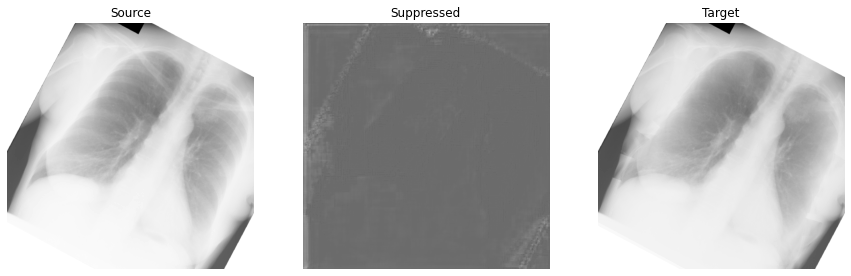

In [3]:
# Image Display
plt.figure(1)
batch_idx = 3
fig, ax = plt.subplots(1,3, figsize=(15,15))
# Reconstructed Images to be displayed
source = InverseHaarTransform(sample["source"][batch_idx,0,:], sample["source"][batch_idx,1,:], sample["source"][batch_idx,2,:], sample["source"][batch_idx,3,:])
ax[0].imshow(source, cmap='gray')
ax[0].set_title("Source")
ax[0].axis("off")
model_out = InverseHaarTransform(out[batch_idx,0,:],out[batch_idx,1,:], out[batch_idx,2,:], out[batch_idx,3,:])
ax[1].imshow(model_out , cmap='gray')
ax[1].set_title("Suppressed")
ax[1].axis("off")
true_boneless = InverseHaarTransform(sample["boneless"][batch_idx,0,:], sample["boneless"][batch_idx,1,:], sample["boneless"][batch_idx,2,:], sample["boneless"][batch_idx,3,:])
ax[2].imshow(true_boneless , cmap='gray')
ax[2].set_title("Target")
ax[2].axis("off")



In [4]:
# Analysis
def PSNR(image, reference, max_reference=1.):
    """ 
    Peak Signal-to-Noise Ratio
    Input image and reference assumed to be Torch Tensors of shape [NxCxHxW]
    """
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    rtMSE = torch.sqrt(MSE)
    
    output = 20*torch.log10(max_reference/rtMSE)
    return output.numpy().squeeze()

def NPS():
    """Noise Power Spectrum"""
    

def SSIM(image, reference):
    iters = 0
    out_list = np.ndarray(image.size(0))
    for im in image:
        im = im.numpy()
        im = np.moveaxis(im, 0,-1)
        ref = reference[iters,:].numpy()
        ref = np.moveaxis(ref, 0,-1)
        out = skimage.metrics.structural_similarity(im, ref, multichannel=True)
        out_list[iters]=out
        iters+=1
    return out_list

print(PSNR(out, sample["boneless"]))
print(SSIM(out, sample["boneless"]))


[[-3.6790104   3.6923652   3.4662602   5.1394105 ]
 [-3.8641765   4.6730328   3.3233783   5.424285  ]
 [-3.45842    -0.20220572  2.520011    2.79695   ]
 [-3.9022353   3.9265587   3.7228036   5.0255938 ]
 [-4.4502873   2.3753662   2.8253605   4.16304   ]
 [-3.9268532   3.7770948   3.7300923   5.337391  ]
 [-4.164735    4.32259     3.609723    5.0752897 ]
 [-3.7957075   4.8282866   3.581959    5.7739778 ]
 [-3.9438531   0.44256982  2.3079019   3.98085   ]
 [-4.007348    3.6114922   3.348754    5.446826  ]]
[0.14958657 0.16533012 0.14851352 0.20355372 0.15556877 0.16395553
 0.16669203 0.16820944 0.15542401 0.17839538]
